### 3.0 Load Data, Remove NaN & Outliers

This code is used to run algorithms in C, get predictions and inference times (in nano seconds), send them back to the Python code to evaluate the accuracy and save the results. 
A detailed description of Python-to-C linking is in the tips folder.
1) Load data and remove outliers
2) Move your C codes, Python wrapers, and .so files to the same directory
3) Run the algorithms, get results, and save them

In [1]:
import pandas as pd
import numpy as np

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

In [ ]:
# use those lines from the Anaconda terminal to generate the .so files from the C codes. 
gcc -o LR.so -shared -fPIC -O2 LR.c
gcc -o SVM.so -shared -fPIC -O2 SVM.c
gcc -o DT.so -shared -fPIC -O2 DT.c
gcc -o RF.so -shared -fPIC -O2 RF.c

C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.fi

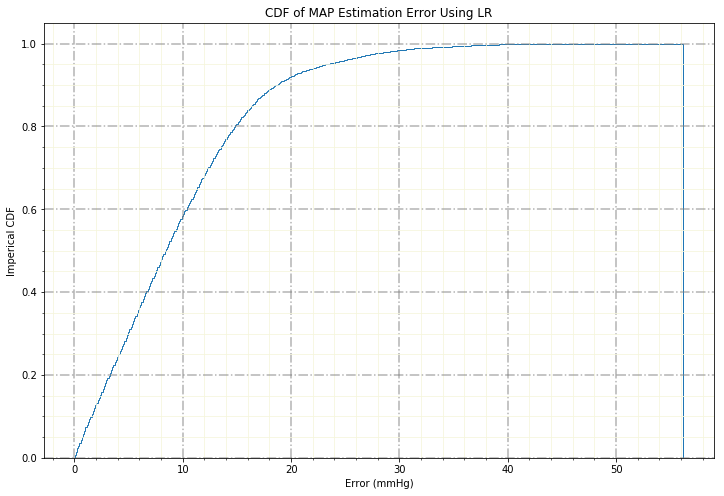

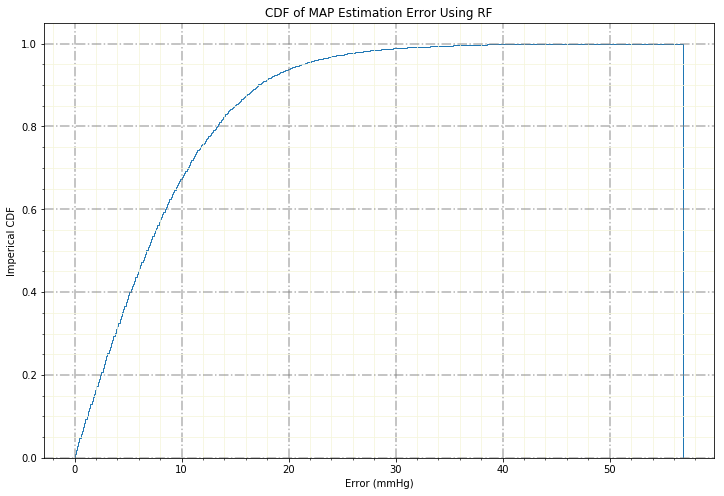

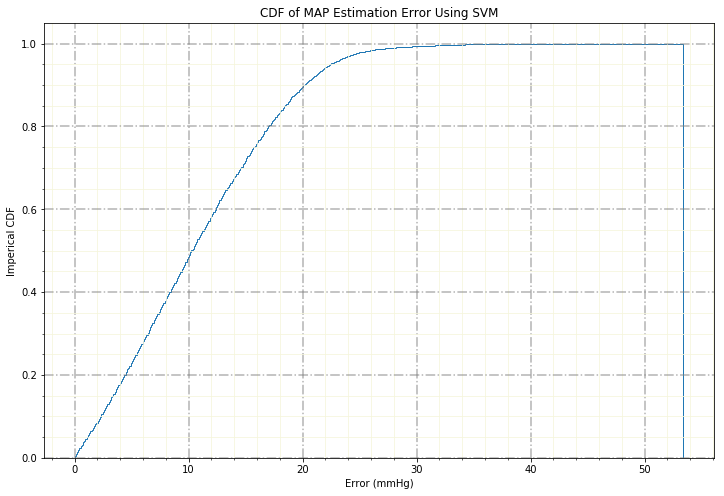

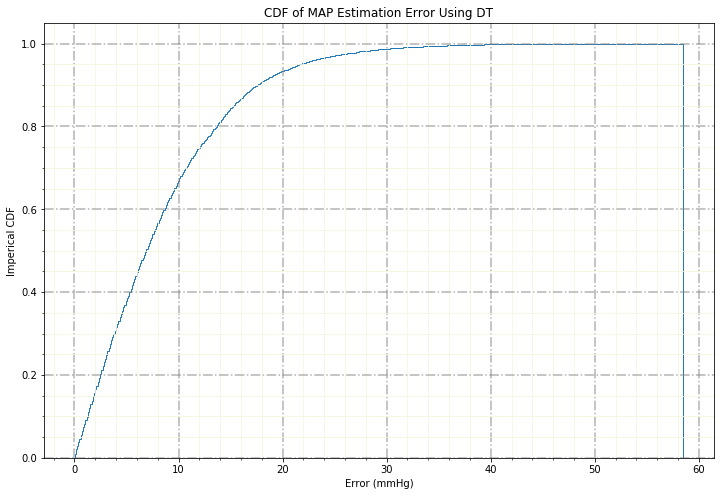

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")
#from LRt_module import LRt_c
from LR_module import LR_c
from SVM_module import SVM_c
from DT_module import DT_c
from RF_module import RF_c

TARGET = 'MAP' # SBP or DBP or MAP
Results_file = TARGET+'_Results_'+'.txt'

Reg_Model_vec = ['LR', 'RF', 'SVM', 'DT']

temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)


for Reg_Model in Reg_Model_vec:
    C_Outputs = pd.DataFrame()
    # Setting Models', Var's, Files', and Graphs' names to be saved
    
    CDF_file = TARGET + '_Error_CDF_' + Reg_Model + '.svg'
    Test_Error_file = TARGET + '_Test_Error_' + Reg_Model + '.pkl'

    if Reg_Model == "LR":
        for i in range(len(test_copy_tr.index)):
            new_list = np.array(test_copy_tr.iloc[i])
            C_list = LR_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)

    if Reg_Model == "SVM":
        for i in range(len(test_copy_tr.index)):
            new_list = np.array(test_copy_tr.iloc[i])
            C_list = SVM_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
            
    if Reg_Model == "DT":
        for i in range(len(test_copy_tr.index)):
            new_list = np.array(test_copy_tr.iloc[i])
            C_list = DT_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
            
    if Reg_Model == "RF":
        for i in range(len(test_copy_tr.index)):
            new_list = np.array(test_copy_tr.iloc[i])
            C_list = RF_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
    
    
    # Errors, ME, MAE, std Calculations:
    
    Test_Error = test_labels.values - C_Outputs['Pred'].values
    Test_ME = np.mean(Test_Error)
    Inf_Times_avg = np.mean(C_Outputs['Inf_Time'])
    Test_std = np.std(Test_Error)
    Test_MAE = np.mean(abs(Test_Error))
    joblib.dump(Test_Error, Test_Error_file)
    
    # Writing Results in Text File: 
    textfile = open(Results_file, 'a')
    textfile.write('Results for ' + Reg_Model + '\n')
    textfile.write('Test ME: ' + str(Test_ME) + '\n')
    textfile.write('Test Std: ' + str(Test_std) + '\n')
    textfile.write('Test MAE: ' + str(Test_MAE) + '\n')
    textfile.write('Average Inference Time: ' + str(Inf_Times_avg) + '\n')
    textfile.write('=========================================' + '\n')
    textfile.close()
    
    # Plot & Save CDF of Error
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.savefig(CDF_file, format='svg', dpi=1200)
    